## Traveling Salesman Problem (TSP)

In the traveling salesman problem, a set of cities is given and the distance between each of them is known. The goal is to find the shortest tour that allows each city to be visited once and only once. In more formal terms, the goal is to find a Hamiltonian tour of minimal length on a fully connected graph. [1] TSP is an NP-hard problem in combinatorial optimization, important in theoretical computer science and operations research.

Below you can see a sample 2-dimensional TSP graph with edges. <br/>
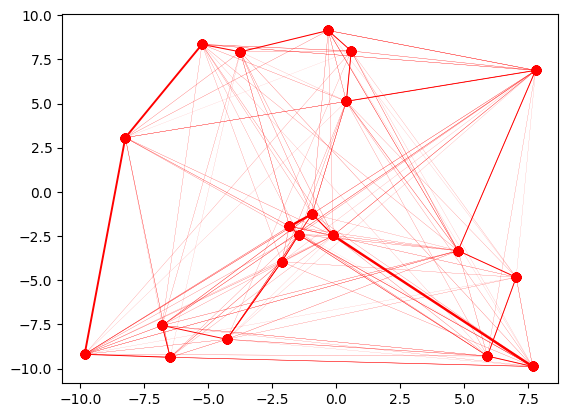

[1] M. Dorigo, M. Birattari and T. Stutzle, "Ant colony optimization," in IEEE Computational Intelligence Magazine, vol. 1, no. 4, pp. 28-39, Nov. 2006, doi: 10.1109/MCI.2006.329691.

In [ ]:
import itertools
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr

### Excercise 1.
Generate some TSP instances. Let's start with smaller graphs - 10 points both in 2 and 3 dimensions. Visualize the points on scatter plots using matplotlib.

### Excercise 2.
Now add edges to those scatter plots. Change their colour or width based on the distance between two points. Do it for the Euclidean and Manhattan distance.

## Ant Colony Optimization algorithm (ACO)
In ant colony optimization, the problem is tackled by simulating a number of artificial ants moving on a graph that encodes the problem itself: each vertex represents a city and
each edge represents a connection between two cities. A variable called pheromone is associated with each edge and can be
read and modified by ants.
Ant colony optimization is an iterative algorithm. At each
iteration, a number of artificial ants are considered. Each of
them builds a solution by walking from vertex to vertex on the
graph with the constraint of not visiting any vertex that she has
already visited in her walk. At each step of the solution construction, an ant selects the following vertex to be visited
according to a stochastic mechanism that is biased by the
pheromone: when in vertex i, the following vertex is selected
stochastically among the previously unvisited ones (see Figure
2). In particular, if j has not been previously visited, it can be
selected with a probability that is proportional to the
pheromone associated with edge (i, j).
At the end of an iteration, on the basis of the quality of the
solutions constructed by the ants, the pheromone values are
modified in order to bias ants in future iterations to construct
solutions similar to the best ones previously constructed. [1]

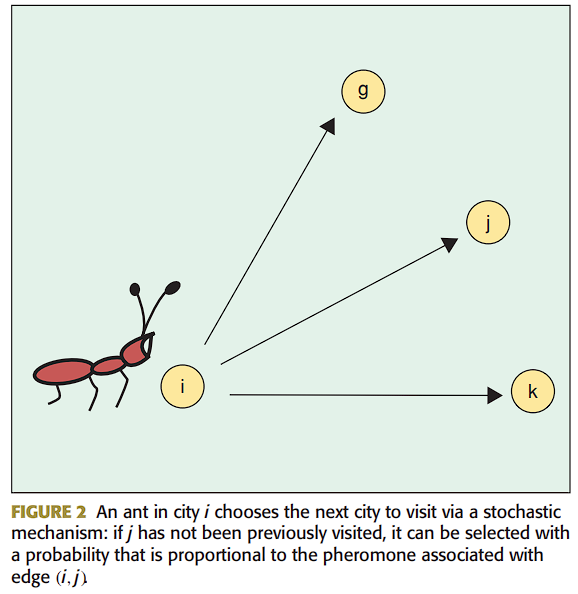

To not reimplement the wheel, the algorithm implementation a modified version of the https://github.com/Akavall/AntColonyOptimization/tree/master?tab=readme-ov-file repository. Thus the implementation contained in the cell just below is subject to the MIT License as follows:

MIT License

Copyright (c) 2018 Kirill Temlyakov

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [40]:
class AntColony(object):

    def __init__(self, distances: np.array, n_ants: int, n_best: int, n_iterations: int, decay: float, alpha: float =1, beta: float =1) -> None:
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1

        Example:
            ant_colony = AntColony(german_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
        """
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self) -> List[Tuple[List[Tuple[int, int]], float, int]]:
        best_history = [] # track the best path found so far
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf, 0)
        for i in range(self.n_iterations):
            all_paths = self._gen_all_paths()
            self._spread_pheronome(all_paths, self.n_best)
            shortest_path = min(all_paths, key=lambda x: x[1])
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = tuple(list(shortest_path) + [i])
                best_history.append(all_time_shortest_path)
            self.pheromone = self.pheromone * self.decay            
        return best_history

    def _spread_pheronome(self, all_paths, n_best):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, _ in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def _gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def _gen_all_paths(self):
        all_paths = []
        for _ in range(self.n_ants):
            path = self._gen_path(0)
            all_paths.append((path, self._gen_path_dist(path)))
        return all_paths

    def _gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for _ in range(len(self.distances) - 1):
            move = self._pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started    
        return path

    def _pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = npr.choice(self.all_inds, 1, p=norm_row)[0]
        return move

In [71]:
distances = np.random.uniform(1, 100, size=(10, 10))
np.fill_diagonal(distances, np.inf)

In [72]:
ant_colony = AntColony(distances, 20, 4, 100, 0.95, alpha=1, beta=1)
path_history = ant_colony.run()
print([path[1:] for path in path_history])
print ("shortest path: {}".format(path_history[-1][1:]))

[(278.44349400091187, 0), (231.44881894566817, 1), (226.5578906640003, 2), (204.4363830124858, 6), (196.91166898803365, 8), (193.34257407385445, 10)]
shortest path: (193.34257407385445, 10)


### Excercise 3.
Take one of the previously generated TSP instances and test ACO algorithm on it with different parameter configurations. You will have to convert the list of points into corresponding distances matrix. Make sure, that evaluation budget remains the same for each run so E.g. offset higher number of ants with smaller number of generations or experiment only with n_best, decay, alpha, beta parameters. For each of the runs add a line to the convergence plot (similarly to lab4). To get more consistent results you may rerun each configuration 10 times and plot the average best solution over time.

### Excercise 4.
Plot snapshots of consequent best solutions (scatter plots with connecting edges) based on path history returned by the AntColony algorithm for singular run.

### Excercise 5.
Come up with a crative distance function (i.e. between some cities there may be hills, combination manhattan with euclidean distance or maybe completely different metric). Distance between 2 cities does not to be the same in both directions. Visualize the connection graph like in excercise 2. Now run ACO on a TSP created using this function and visualize snapshots of consequent best solutions similarly to excercise 4.

## Held–Karp algorithm
During the course of this laboratory, you executed ACO on TSP instances many times. However, you still can not be sure about the quality of solutions you got. In case of continuous optimization, results are compared to the value of optimal point in search space. When it comes to TSP, we have to calculate the length of the shortest route. But TSP is an NP-hard problem which means that we can not exactly solve it in polynomial time. Still in case of benchmarking it is worth to have a lower bound of path length for comparison. For this class of problems a common way to calculate it is using Held-Karp algorithm implemented below.

In [70]:
def held_karp(distances: np.array):
    n = distances.shape[0]
    
    # Initialize the memorization table
    g = {(frozenset([k]), k): distances[0, k] for k in range(1, n)}

    for s in range(2, n+1):
        for subset in itertools.combinations(range(1, n), s):
            subset = frozenset(subset)
            for k in subset:
                g[subset, k] = min(g[subset - {k}, m] + distances[m, k] for m in subset if m != k)

    # Find the optimal solution
    all_nodes = frozenset(range(1, n))
    opt = min(g[all_nodes, k] + distances[k, 0] for k in range(1, n))
    
    return opt

result = held_karp(distances)
print("Optimal TSP cost:", result)

Optimal TSP cost: 121.51179994360962


### Excercise 6.

Generate a TSP and run the Held-Karp algorithm on it (be carefull - computation cost rises exponentialy). Then run ACO algorithm 10 times on the same TSP. Visualize convergence plot from those runs against the theoretical minima marked as horizontal line.